In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys

sys.path.append(os.path.abspath("../"))


import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)


load_dotenv()


from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import get_repo_root

scores = load_clean_scores(["2022-23", "2023-24"])
scores.head(5)

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed
360551,2022-23,2022-10-18,22200001,PHI @ BOS,76ers,sixers,200782,pj tucker,33.016667,3,5,0.600,0,2,0.000,0,0,0.0,2,2,4,0,0,1,2,2,6,-6,12.00,17.15,False
360552,2022-23,2022-10-18,22200001,BOS vs. PHI,celtics,celtics,201143,al horford,23.100000,2,7,0.286,2,5,0.400,0,0,0.0,1,4,5,1,0,0,0,4,6,8,13.75,35.15,False
360553,2022-23,2022-10-18,22200001,BOS vs. PHI,celtics,celtics,201933,blake griffin,8.283333,0,2,0.000,0,1,0.000,1,2,0.5,2,3,5,1,0,0,0,3,1,-5,8.75,0.50,True
360554,2022-23,2022-10-18,22200001,PHI @ BOS,76ers,sixers,201935,james harden,37.266667,9,14,0.643,5,9,0.556,12,12,1.0,0,8,8,7,0,0,3,3,35,1,54.00,44.05,True
360555,2022-23,2022-10-18,22200001,PHI @ BOS,76ers,sixers,202699,tobias harris,34.233333,7,14,0.500,3,6,0.500,1,2,0.5,1,1,2,0,3,0,0,3,18,-1,26.50,25.95,True


## Training Function

In [2]:
from src.utils import compute_auc_roc


def train_and_plot(train, test, feature_names, target_name):
    X_train, X_test = train[feature_names], test[feature_names]
    y_train, y_test = train[target_name], test[target_name]

    # ---- Train XGBoost model ----
    model = XGBRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    )
    model.fit(X_train, y_train)

    # ---- Evaluate the model ----
    y_pred = model.predict(X_test)

    display(df_xg.head())

    # 5-day moving average performance
    print(
        "Sliding Window MAE:",
        np.mean(np.abs(y_test - test_df["projectedFantasyPoints"])),
    )
    print("Model MAE:", np.mean(np.abs(y_test - y_pred)))

    result_dct = {
        "model": model,
        "x_train": X_train,
        "y_train": y_train,
        "x_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
    }
    return result_dct

## Load Podcast Data

In [3]:
from src.data_utils import PodcastContainer

cont = PodcastContainer(
    {
        "rotowire": PodcastContainer.ROTOWIRE_DIR,
        # "nbatoday": PodcastContainer.NBATODAY_DIR,
    }
)
pod_df = cont.get_all_episodes()
pod_df = pod_df[pod_df.file_name.str.contains("week_15")]
pod_df

,publication_date,file_name,file_path,content,duration,podcast_name
56,2024-01-26,fantasy_basketball_waiver_wire_for_week_15_202324,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome everybody to the award winning rotor w...,2839,rotowire


## Extract LLM Features and Plot as a Predictor

C:\Users\Patrick\My Drive\Columbia\Practical Deep Learning\FantasyPodcastInsights\src\llm_feature_extractor.py:320: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  self.embeddings_model = OpenAIEmbeddings()
0it [00:00, ?it/s]

Loading from disk: chunk_embeddings.pkl
Loading from disk: player_chunk_mapping.pkl


1it [00:47, 47.09s/it]


rows: 194
count    194.000000
mean       0.057474
std        0.244013
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.800000
Name: increased_playing_time, dtype: float64
AUC: 0.4967948717948718


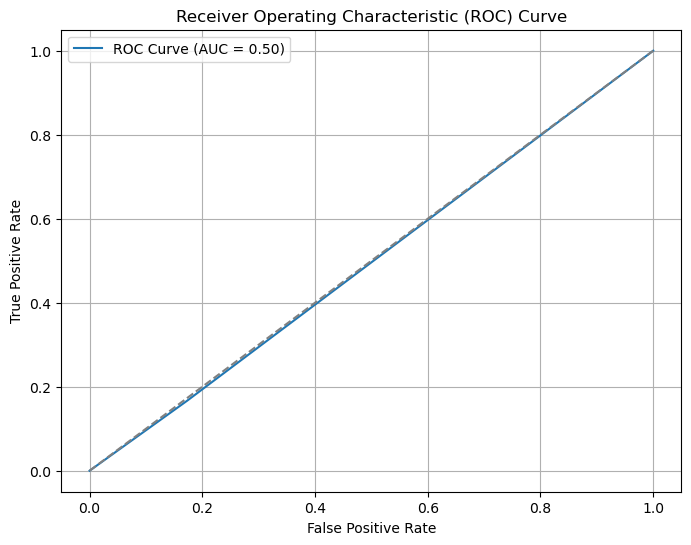

0.4967948717948718

In [4]:
from sklearn.model_selection import train_test_split
from src.llm_feature_extractor import FaissFeatureExtractor
from src.model_xg import add_lagged_features
from xgboost import XGBRegressor

# Extract features
faiss_fe = FaissFeatureExtractor()
feats = faiss_fe.extract_llm_feats(pod_df)

lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

df_xg, new_feats = add_lagged_features(scores, lag_features, 5)
df_xg = df_xg.dropna()

# Merge with LLM features
df_xg = pd.merge_asof(
    df_xg,
    feats,
    left_on="game_date",
    right_on="podcast_date",
    by="personName",
    tolerance=pd.Timedelta("5d"),
)
df_xg = df_xg.dropna()

# Split training/validation sets
train_size = int(len(df_xg) * 0.8)
train_df = df_xg.iloc[train_size:]
test_df = df_xg.iloc[:train_size]

print(f"rows: {len(df_xg)}")
print(df_xg["increased_playing_time"].describe())


# ---- Plot AUC of the feature only ---
from src.utils import compute_auc_roc

d = df_xg[["outperformed", "increased_playing_time"]]
d = d.assign(
    outperformed=np.where(d["outperformed"], 1, 0),
    playing_time=np.where(d["increased_playing_time"] > 0, 1, 0),
)
compute_auc_roc(d["outperformed"], d["playing_time"])

## Train XGBoost with LLM Features

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_4,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,podcast_name,podcast_date,increased_playing_time
45899,2023-24,2024-01-26,22300634,DAL @ ATL,mavericks,mavericks,203501,tim hardaway jr,32.150000,3,12,0.250,3,9,0.333,4,4,1.000,1,3,4,3,0,0,2,2,13,-5,21.50,29.55,False,34.266667,31.95,28.283333,40.633333,39.333333,16.0,13.0,17.0,23.0,17.0,0.375,0.615,0.294,0.478,0.471,10.0,7.0,7.0,15.0,...,10.0,6.0,0.500,0.000,1.000,1.000,0.833,5.0,2.0,2.0,2.0,4.0,5.0,2.0,4.0,2.0,4.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,1.0,2.0,2.0,0.0,3.0,17.0,20.0,12.0,41.0,24.0,rotowire,2024-01-26,0.25
45902,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203991,clint capela,24.566667,4,7,0.571,0,0,0.000,2,3,0.667,3,5,8,2,0,1,1,2,10,-7,24.50,25.30,False,24.666667,22.00,22.100000,22.216667,27.300000,9.0,10.0,8.0,4.0,6.0,0.333,0.400,0.375,0.500,1.000,0.0,0.0,0.0,0.0,...,7.0,0.0,0.714,0.750,0.000,0.714,0.000,8.0,6.0,4.0,6.0,3.0,11.0,12.0,9.0,11.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,2.0,2.0,3.0,11.0,11.0,6.0,9.0,12.0,rotowire,2024-01-26,0.00
45903,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203992,bogdan bogdanovic,27.266667,9,22,0.409,4,9,0.444,2,2,1.000,2,2,4,2,2,0,0,2,24,3,36.00,23.05,True,32.516667,33.60,28.333333,34.916667,23.916667,11.0,12.0,11.0,15.0,7.0,0.545,0.417,0.455,0.400,0.571,9.0,8.0,6.0,7.0,...,2.0,2.0,1.000,1.000,0.750,1.000,1.000,0.0,2.0,2.0,3.0,3.0,0.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,0.0,2.0,1.0,17.0,18.0,14.0,17.0,12.0,rotowire,2024-01-26,0.00
45905,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1627749,dejounte murray,37.050000,9,18,0.500,3,7,0.429,1,2,0.500,1,4,5,7,0,0,3,3,22,-21,37.25,46.60,False,33.216667,40.10,34.716667,39.766667,36.033333,19.0,23.0,19.0,22.0,18.0,0.368,0.478,0.526,0.409,0.611,7.0,10.0,7.0,7.0,...,1.0,3.0,0.875,0.875,1.000,1.000,1.000,4.0,10.0,9.0,3.0,4.0,7.0,10.0,9.0,3.0,5.0,7.0,6.0,5.0,11.0,5.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,5.0,2.0,1.0,2.0,2.0,1.0,23.0,35.0,24.0,22.0,26.0,rotowire,2024-01-26,0.00
45907,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1629027,trae young,33.183333,9,18,0.500,2,7,0.286,10,11,0.909,0,1,1,11,3,0,2,3,30,9,54.25,39.75,True,28.3

Sliding Window MAE: 9.242903225806451
Model MAE: 10.4216063518678
AUC: 0.6116666666666666


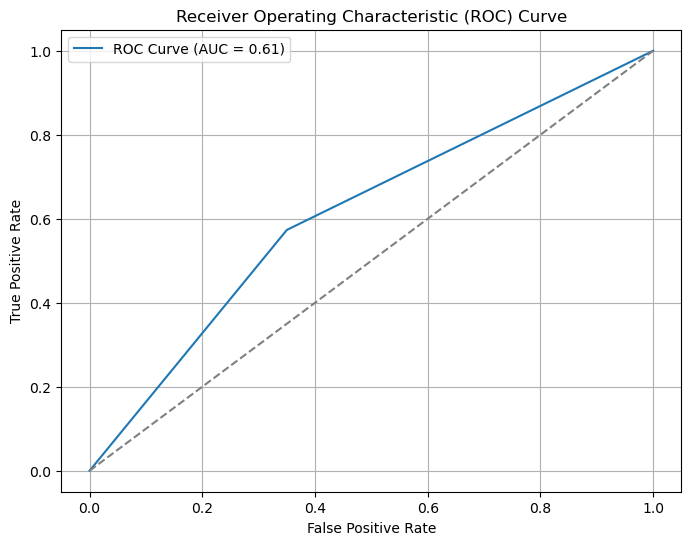

0.6116666666666666

In [19]:
llm_features = ["increased_playing_time"]
select_features = ["plusMinusPoints"] + llm_features + new_feats
target_col = "fantasyPoints"
result_dct = train_and_plot(train_df, test_df, select_features, target_col)
y_pred = result_dct["y_pred"]

compute_auc_roc(
    test_df["outperformed"],
    np.where(y_pred > test_df["projectedFantasyPoints"], True, False),
)

## Train Baseline Model

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_4,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,podcast_name,podcast_date,increased_playing_time
45899,2023-24,2024-01-26,22300634,DAL @ ATL,mavericks,mavericks,203501,tim hardaway jr,32.150000,3,12,0.250,3,9,0.333,4,4,1.000,1,3,4,3,0,0,2,2,13,-5,21.50,29.55,False,34.266667,31.95,28.283333,40.633333,39.333333,16.0,13.0,17.0,23.0,17.0,0.375,0.615,0.294,0.478,0.471,10.0,7.0,7.0,15.0,...,10.0,6.0,0.500,0.000,1.000,1.000,0.833,5.0,2.0,2.0,2.0,4.0,5.0,2.0,4.0,2.0,4.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,1.0,2.0,2.0,0.0,3.0,17.0,20.0,12.0,41.0,24.0,rotowire,2024-01-26,0.0
45902,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203991,clint capela,24.566667,4,7,0.571,0,0,0.000,2,3,0.667,3,5,8,2,0,1,1,2,10,-7,24.50,25.30,False,24.666667,22.00,22.100000,22.216667,27.300000,9.0,10.0,8.0,4.0,6.0,0.333,0.400,0.375,0.500,1.000,0.0,0.0,0.0,0.0,...,7.0,0.0,0.714,0.750,0.000,0.714,0.000,8.0,6.0,4.0,6.0,3.0,11.0,12.0,9.0,11.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,2.0,2.0,3.0,11.0,11.0,6.0,9.0,12.0,rotowire,2024-01-26,0.0
45903,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203992,bogdan bogdanovic,27.266667,9,22,0.409,4,9,0.444,2,2,1.000,2,2,4,2,2,0,0,2,24,3,36.00,23.05,True,32.516667,33.60,28.333333,34.916667,23.916667,11.0,12.0,11.0,15.0,7.0,0.545,0.417,0.455,0.400,0.571,9.0,8.0,6.0,7.0,...,2.0,2.0,1.000,1.000,0.750,1.000,1.000,0.0,2.0,2.0,3.0,3.0,0.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,0.0,2.0,1.0,17.0,18.0,14.0,17.0,12.0,rotowire,2024-01-26,0.0
45905,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1627749,dejounte murray,37.050000,9,18,0.500,3,7,0.429,1,2,0.500,1,4,5,7,0,0,3,3,22,-21,37.25,46.60,False,33.216667,40.10,34.716667,39.766667,36.033333,19.0,23.0,19.0,22.0,18.0,0.368,0.478,0.526,0.409,0.611,7.0,10.0,7.0,7.0,...,1.0,3.0,0.875,0.875,1.000,1.000,1.000,4.0,10.0,9.0,3.0,4.0,7.0,10.0,9.0,3.0,5.0,7.0,6.0,5.0,11.0,5.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,5.0,2.0,1.0,2.0,2.0,1.0,23.0,35.0,24.0,22.0,26.0,rotowire,2024-01-26,0.0
45907,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1629027,trae young,33.183333,9,18,0.500,2,7,0.286,10,11,0.909,0,1,1,11,3,0,2,3,30,9,54.25,39.75,True,28.30000

Sliding Window MAE: 30.017096774193547
Model MAE: 0.45522246
AUC: 0.5020833333333333


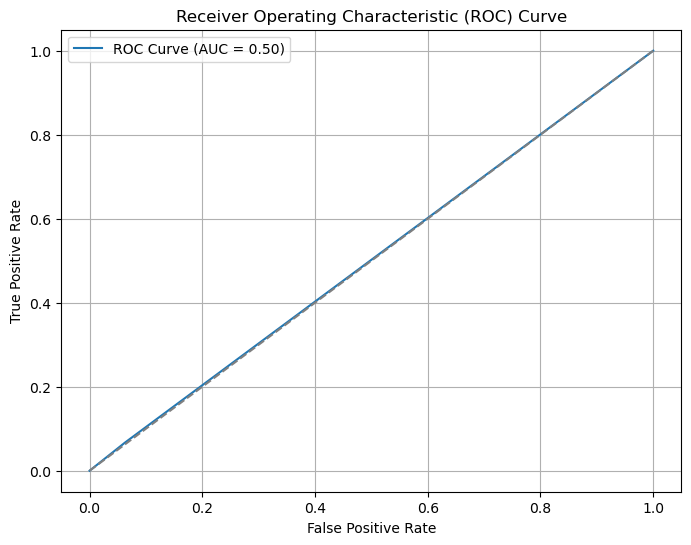

0.5020833333333333

In [10]:
select_features = ["plusMinusPoints", "projectedFantasyPoints"] + new_feats
# target_col = "fantasyPoints"
target_col = 'outperformed'

result = train_and_plot(train_df, test_df, select_features, target_col)
y_pred = result["y_pred"]

# compute_auc_roc(
#     test_df["outperformed"],
#     np.where(y_pred > test_df["projectedFantasyPoints"], True, False),
# )

compute_auc_roc(
    test_df["outperformed"],
    np.where(y_pred < 0, True, False),
)